In [1]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

image = preprocess(Image.open("./CLIP/CLIP.png")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[0.9927   0.004253 0.003063]]


In [3]:
from jarvis.core.atoms import crop_square
import matplotlib.pyplot as plt
import os, glob
from jarvis.analysis.stem.convolution_apprx import STEMConv
from jarvis.db.figshare import data, get_jid_data
import matplotlib.pyplot as plt
from jarvis.core.atoms import Atoms, ase_to_atoms, get_supercell_dims
from jarvis.core.lattice import get_2d_lattice
from sklearn.model_selection import train_test_split
from collections import defaultdict

In [7]:
from jarvis.db.figshare import data

dft_3d = data('dft_3d')

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.


In [10]:
a = Atoms.from_dict(dft_3d[1]["atoms"])
jid = dft_3d[1]["jid"]
jid

'JVASP-86097'

In [27]:
a

System
1.0
4.089078911208881 0.0 0.0
-0.0 4.089078911208881 -0.0
0.0 -0.0 4.089078911208881
Dy B 
1 6 
direct
0.0 0.0 0.0 Dy
0.19861408290185742 0.5 0.5 B
0.5 0.8013859170981429 0.5 B
0.5 0.19861408290185742 0.5 B
0.8013859170981429 0.5 0.5 B
0.5 0.5 0.19861408290185742 B
0.5 0.5 0.8013859170981429 B

In [11]:
dims = get_supercell_dims(atoms=a, enforce_c_size=1)
s = a.make_supercell_matrix(dims)

In [12]:
c = crop_square(s, csize=5)

In [13]:
p = STEMConv(output_size=[128, 128]).simulate_surface(atoms=c)[0]


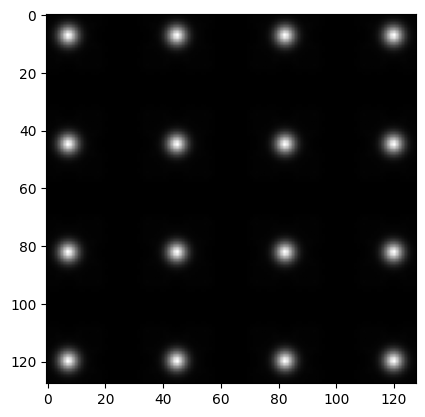

In [14]:
plt.imshow(p, cmap='gray')

In [17]:
from datasets import load_dataset

data_train = load_dataset("json", data_files="./dataset/alpaca_mbj_bandgap_train.json", split="train")

/home/jipengsun/.conda/envs/clipp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 17824 examples [00:00, 140659.27 examples/s]


In [24]:
gen_str = data_train["response"][0]

from jarvis.core.atoms import Atoms
from pymatgen.core import Structure
from pymatgen.core.lattice import Lattice

In [ ]:
def str_to_structure(gen_str):
    lines = [x for x in gen_str.split("\n") if len(x) > 0]
    lengths = [float(x) for x in lines[0].split(" ")]
    angles = [float(x) for x in lines[1].split(" ")]
    species = [x for x in lines[2::2]]
    coords = [[float(y) for y in x.split(" ")] for x in lines[3::2]]
    
    structure = Structure(
        lattice=Lattice.from_parameters(
            *(lengths + angles)),
        species=species,
        coords=coords, 
        coords_are_cartesian=False,
    )
    
    return structure

gen = parse_fn(gen_str)
gen

Structure Summary
Lattice
    abc : 4.9 6.900000000000001 11.6
 angles : 77.00000000000001 78.0 68.99999999999999
 volume : 353.2516730365913
      A : np.float64(4.792923243595648) np.float64(0.0) np.float64(1.0187672850070213)
      B : np.float64(2.198059032436943) np.float64(6.353686234153686) np.float64(1.552162274972668)
      C : np.float64(0.0) np.float64(0.0) np.float64(11.6)
    pbc : True True True
PeriodicSite: Te (2.631, 5.528, 4.983) [0.15, 0.87, 0.3]
PeriodicSite: Te (5.501, 3.431, 3.959) [0.9, 0.54, 0.19]
PeriodicSite: Te (1.49, 2.923, 10.21) [0.1, 0.46, 0.81]
PeriodicSite: Te (2.92, 1.652, 5.891) [0.49, 0.26, 0.43]
PeriodicSite: Te (4.071, 4.702, 8.28) [0.51, 0.74, 0.57]
PeriodicSite: Te (4.36, 0.826, 9.188) [0.85, 0.13, 0.7]
PeriodicSite: Se (3.489, 1.08, 1.97) [0.65, 0.17, 0.09]
PeriodicSite: Se (3.502, 5.274, 12.2) [0.35, 0.83, 0.91]
PeriodicSite: O (0.4454, 0.3177, 10.12) [0.07, 0.05, 0.86]
PeriodicSite: O (6.546, 6.036, 4.046) [0.93, 0.95, 0.14]
PeriodicSite: O (2

In [43]:
from jarvis.core.atoms import Atoms
from pymatgen.core.structure import Structure
import jarvis
atoms_pred = jarvis.core.atoms.pmg_to_atoms(gen)
atoms_pred

System
1.0
4.792923243595648 0.0 1.0187672850070213
2.198059032436943 6.353686234153686 1.552162274972668
0.0 0.0 11.6
Te Se O 
6 2 16 
direct
0.15 0.87 0.3 Te
0.9 0.54 0.19 Te
0.1 0.46 0.81 Te
0.49 0.26 0.43 Te
0.51 0.74 0.57 Te
0.85 0.13 0.7 Te
0.65 0.17 0.09 Se
0.35 0.83 0.91 Se
0.07 0.05 0.86 O
0.93 0.95 0.14 O
0.17 0.68 0.68 O
0.83 0.32 0.32 O
0.51 0.29 0.81 O
0.26 0.03 0.56 O
0.74 0.97 0.44 O
0.36 0.69 0.44 O
0.64 0.31 0.56 O
0.41 0.22 0.21 O
0.59 0.78 0.79 O
0.81 0.36 0.06 O
0.19 0.64 0.94 O
0.49 0.71 0.19 O
0.99 0.64 0.33 O
0.01 0.36 0.67 O

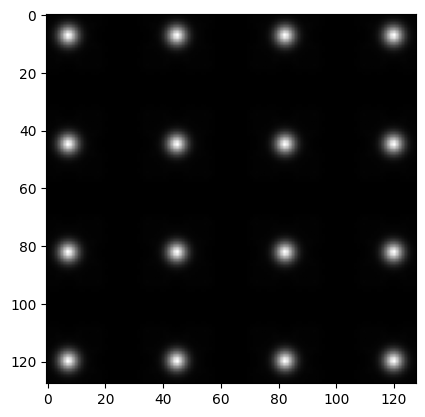

In [45]:
dims = get_supercell_dims(atoms=atoms_pred, enforce_c_size=1)
s = a.make_supercell_matrix(dims)
c = crop_square(s, csize=5)
p = STEMConv(output_size=[128, 128]).simulate_surface(atoms=c)[0]
plt.imshow(p, cmap='gray')